# 1. Urban Sprawl

### Latar Belakang
Urban sprawl atau penyebaran wilayah perkotaan merupakan fenomena global yang ditandai dengan pertumbuhan kota yang tidak terkendali. Fenomena ini seringkali terjadi akibat terbatasnya ruang di pusat kota, sehingga mendorong ekspansi fisik ke wilayah pinggiran secara sporadis, dengan kepadatan rendah dan tata ruang yang terfragmentasi (Dadashpoor & Shahhossein, 2024). Di Indonesia, urban sprawl menjadi tantangan besar seiring meningkatnya urbanisasi. Dari tahun 1990 hingga 2020, proporsi penduduk perkotaan meningkat dari 30% menjadi 56% (BPS, 2020). Pertumbuhan ini, jika tidak dikelola, berdampak pada:

Lingkungan: konversi lahan pertanian menjadi lahan terbangun (Sartika, 2012; Mardiansjah et al., 2019),

Sosial: peningkatan ketimpangan sosial akibat suburbanisasi dan alih fungsi lahan (Desiyana, 2016),

Ekonomi: beban biaya pembangunan infrastruktur yang lebih mahal akibat penyebaran yang tidak efisien (Nechyba & Walsh, 2004),

Transportasi: meningkatnya ketergantungan pada kendaraan pribadi (Yunus, 2000).

# 2. Metode

Dua pendekatan utama yang digunakan dalam modul ini:

Urban Expansion Intensity Index (UEII) –> untuk mengukur seberapa cepat ekspansi terjadi berdasarkan grid spasial (Indrawati et al., 2020),

Shannon's Entropy –> untuk mengukur tingkat penyebaran atau konsentrasi pembangunan berdasarkan batas administratif desa/kecamatan (Effat & Elshobaki, 2015).

## Library yang Digunakan

Notebook ini menggunakan berbagai pustaka Python untuk analisis spasial dan citra satelit:

- `numpy` → Operasi numerik dan masking NaN
- `rasterio`, `rioxarray` → Membaca dan menulis data raster (GeoTIFF)
- `geopandas`, `shapely` → Baca SHP dan manipulasi geometri spasial
- `matplotlib` → Visualisasi data raster dan spasial
- `xarray`, `ma` → Menyimpan raster hasil interpolasi IDW
- `rasterstats` → Menghitung zonal statistics
- `scipy` → Interpolasi IDW menggunakan KDTree
- `pandas` → Tabel hasil klasifikasi dan statistik

> Semua pustaka diimpor satu kali dan akan digunakan dalam berbagai bagian metode seperti UEII dan Shannon's Entropy.


In [ ]:
# === Array, Raster, dan Statistik ===
import numpy as np
import pandas as pd
import rasterio
import rioxarray
import xarray as xr
import numpy.ma as ma

# === Visualisasi ===
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.patches as mpatches

# === Data Spasial ===
import geopandas as gpd
from shapely.geometry import box
from rasterio.transform import from_origin
from rasterstats import zonal_stats

# === Interpolasi IDW ===
from scipy.spatial import cKDTree

## 2.1 Urban Expansion Intensity Index (UEII)

UEII dikembangkan untuk mengukur seberapa cepat dan intens pembangunan terjadi dalam suatu unit spasial selama periode waktu tertentu. Nilai UEII dihitung untuk setiap unit grid secara individual, sehingga memungkinkan visualisasi spasial ekspansi urban secara rinci.

### Rumus UEII :
(diadaptasi dari Indrawati et al., 2020)


UEII = ((UA akhir - UA awal) / (n × luas grid)) × 100

Keterangan:
- UEII : Urban Expansion Intensity Index
- UA awal : Luas lahan terbangun pada tahun awal (misalnya tahun 1995)
- UA akhir : Luas lahan terbangun pada tahun akhir (misalnya tahun 2022)
- n : Rentang waktu dalam tahun (27 tahun)
- luas grid : Luas total satu unit grid (misalnya 6,25 hektar untuk grid 250 × 250 meter)

Hasil UEII menggambarkan intensitas ekspansi perkotaan dari suatu unit spasial relatif (satu grid) terhadap keseluruhan wilayah studi. Kriteria nilai UEII adalah sebagai berikut:

| Kategori UEII       | Nilai UEII |
|---------------------|----------------|
| Decreasing Intensity      | = < 0 (Negative Values)            |
| Zero Urban Expansion      | = 0            |
| Slow Urban Expansion      | 0 – 0.28         |
| Low Urban Expansion       | 0.28 – 0.59         |
| Medium Urban Expansion  | 0.59 – 1.05        |
| High Urban Expansion      | 1.05 – 1.92        |
| Very High Urban Expansion | > 1.92    |

Klasifikasi ini diadaptasi dari studi **(Kassouk et al., 2022 ; Alam et al., 2023)**.

### Pembuatan Grid Spasial (UEII)
Dalam metode Urban Expansion Intensity Index (UEII), wilayah studi dibagi ke dalam unit grid dengan ukuran tetap untuk menghitung intensitas perubahan lahan terbangun secara spasial. Dalam studi ini, digunakan grid berukuran **0.25 km x 0.25 km** atau **250 m x 250 m** sebagai satuan analisis spasial.

Pemilihan grid dilakukan untuk meminimalkan bias yang muncul dari penggunaan batas administratif yang tidak seragam ukurannya. Metode grid tetap ini digunakan oleh **Indrawati et al. (2020)** dalam penelitiannya mengenai ekspansi urban di Semarang.

#### Langkah-langkah:
1. Membaca shapefile batas wilayah (misalnya Solo Raya).
2. Menyeleksi wilayah seperti Kabupaten Wonogiri sebagai wilayah kajian.
3. Menghitung batas spasial minimum dan maksimum.
4. Membuat grid persegi secara otomatis berdasarkan ukuran 250 meter.
5. Memotong grid agar hanya mencakup wilayah administratif yang telah dipilih/diseleksi (Wonogiri).

In [26]:
# Library yang digunakan
import geopandas as gpd  # Untuk membaca file SHP dan memproses geometri spasial
import numpy as np       # Untuk membuat array range koordinat grid
from shapely.geometry import box  # Untuk membuat geometri persegi (grid)


# Baca batas wilayah Solo Raya
roi = gpd.read_file('kawasan solo raya/SoloRaya.shp').to_crs("EPSG:32749")  # Pastikan UTM

wonogiri = roi[roi["Kab_Kota"] == "WONOGIRI"].copy()
minx, miny, maxx, maxy = wonogiri.total_bounds

# Ukuran grid dalam meter
grid_size = 250  # 0.25 km

# Buat grid
cols = np.arange(minx, maxx, grid_size)
rows = np.arange(miny, maxy, grid_size)

grid_cells = []
for x in cols:
    for y in rows:
        cell = box(x, y, x + grid_size, y + grid_size)
        grid_cells.append(cell)

grid = gpd.GeoDataFrame(geometry=grid_cells, crs=wonogiri.crs)

# Potong grid agar hanya dalam batas studi
grid_clipped = gpd.overlay(grid, wonogiri, how='intersection')
#grid_clipped.to_file("grid_025_solo.geojson", driver="GeoJSON")


### Visualisasi Grid

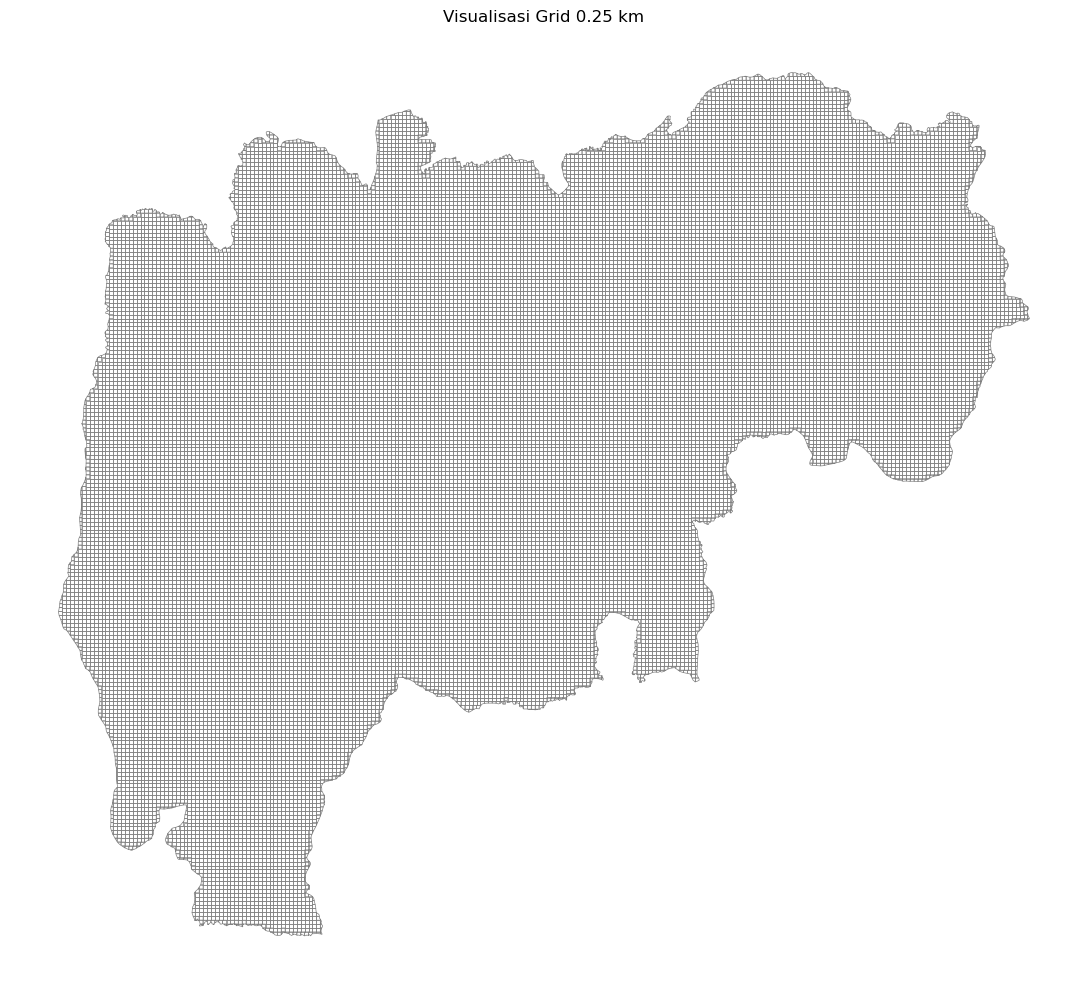

In [27]:
# Library yang digunakan

import matplotlib.pyplot as plt  # Untuk plotting dan visualisasi

# Membuat figure dan axes
fig, ax = plt.subplots(figsize=(22, 10))

# edgecolor = warna garis tepi antar grid
# facecolor = 'none' berarti isi grid transparan
# linewidth = ketebalan garis batas
grid_clipped.plot(ax=ax, edgecolor="gray", facecolor="none", linewidth=0.5)

# Menambahkan judul peta
ax.set_title("Visualisasi Grid 0.25 km", fontsize=12)

# Menyembunyikan sumbu X dan Y agar tampilan lebih bersih
ax.set_axis_off()

# Menyesuaikan tata letak agar tidak terpotong
plt.tight_layout()

# Menampilkan peta
plt.show()

## Ekstraksi Luas Lahan Terbangun per Grid (Zonal Statistics)

Setelah membuat unit analisis berbentuk grid, langkah berikutnya adalah menghitung luas lahan terbangun (built-up) dalam setiap grid pada dua periode waktu (tahun 1995 dan 2022).

Untuk melakukan ini, digunakan metode **zonal statistics**, yaitu proses mengambil statistik (jumlah pixel) dari raster berdasarkan zona poligon tertentu (dalam hal ini, grid 0.25 km).

Raster klasifikasi lahan memiliki 3 kelas:
- 1 = Built-up (terbangun)
- 2 = Badan air
- 3 = Non-built-up

Karena Urban Expansion Intensity Index (UEII) hanya menghitung pertumbuhan built-up, maka hanya kelas **1** yang dihitung per grid.

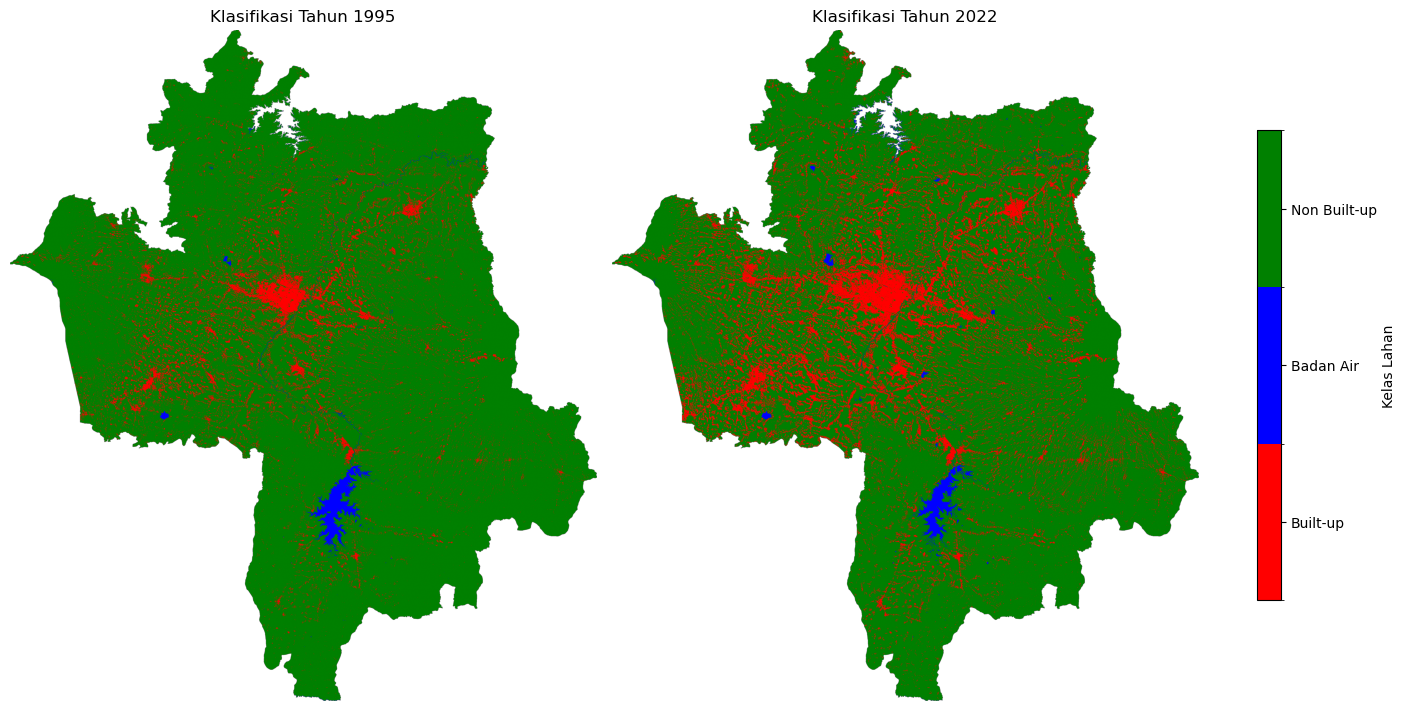

In [28]:
# IMPORT DATA RASTER
# Ganti path ini ke file raster klasifikasi Anda
class95 = "Landcover 3class/landcover_1995_3class.tif"
class22 = "Landcover 3class/landcover_2022_3class.tif"

# Fungsi untuk membaca raster sebagai float agar bisa mengandung NaN (NoData = 0) untuk masking nilai NoData
def read_clean(path):
    with rasterio.open(path) as src:
        data = src.read(1).astype(float)
        data[data == 0] = np.nan  # Masking NoData (0)
    return data

# Baca data
data_95 = read_clean(class95)
data_22 = read_clean(class22)

# SETUP WARNA & LABEL
# Nilai: 1 = built-up, 2 = air, 3 = non-built-up
colors = ["red", "blue", "green"]
labels = ["Built-up", "Badan Air", "Non Built-up"]
bounds = [0.5, 1.5, 2.5, 3.5]
cmap = ListedColormap(colors)
norm = BoundaryNorm(bounds, cmap.N)

# PLOTTING KEDUA CITRA
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7), constrained_layout=True)

im1 = ax1.imshow(data_95, cmap=cmap, norm=norm)
ax1.set_title("Klasifikasi Tahun 1995")
ax1.axis("off")

im2 = ax2.imshow(data_22, cmap=cmap, norm=norm)
ax2.set_title("Klasifikasi Tahun 2022")
ax2.axis("off")

# Menambahkan colorbar
cbar = fig.colorbar(im2, ax=[ax1, ax2], orientation="vertical", shrink=0.7, ticks=[1, 2, 3])
cbar.ax.set_yticklabels(labels)
cbar.set_label("Kelas Lahan")

plt.show()

In [ ]:
# === ZONAL STATS UNTUK BUILT-UP (kelas 1) ===
# Menghitung jumlah pixel built-up dalam setiap grid

stats_1995 = zonal_stats(
    grid_clipped,
    class95,
    stats="count",
    categorical=True,
    category_map={1: "builtup"},
    nodata=0
)

stats_2022 = zonal_stats(
    grid_clipped,
    class22,
    stats="count",
    categorical=True,
    category_map={1: "builtup"},
    nodata=0
)

# Tambahkan hasil statistik ke dalam GeoDataFrame grid
grid_clipped["builtup_1995"] = [s.get("builtup", 0) for s in stats_1995]
grid_clipped["builtup_2022"] = [s.get("builtup", 0) for s in stats_2022]

In [ ]:
# KONVERSI PIXEL BUILT-UP KE HEKTAR

# Set nilai luas 1 pixel Landsat (30m x 30m) = 900 m² = 0.09 hektar
pixel_area_ha = 0.09

# Konversi hasil zonal stats dari jumlah piksel menjadi hektar (tahun 1995)
grid_clipped["builtup_1995_ha"] = grid_clipped["builtup_1995"] * pixel_area_ha

# Konversi hasil zonal stats dari jumlah piksel menjadi hektar (tahun 2022)
grid_clipped["builtup_2022_ha"] = grid_clipped["builtup_2022"] * pixel_area_ha

# Tampilkan isi GeoDataFrame (dapat juga diganti dengan grid_clipped.head())
grid_clipped

# (Opsional) Simpan GeoDataFrame hasil ke file untuk keperluan selanjutnya
#grid_clipped.to_file("grid_wonogiri_builtup_stats.shp")

## PERHITUNGAN DAN KLASIFIKASI UEII (Urban Expansion Intensity Index)

In [16]:
# Luas tetap per grid: 250m x 250m = 62.500 m² = 6.25 hektar
grid_area_ha = 6.25

# Rentang waktu antara dua tahun (misal: 1995 ke 2022)
tahun_selisih = 2022 - 1995  # = 27 tahun

# Hitung UEII untuk setiap grid
# Rumus: ((built-up akhir - built-up awal) / (luas grid × selisih tahun)) × 100
grid_clipped["UEII"] = (
    (grid_clipped["builtup_2022_ha"] - grid_clipped["builtup_1995_ha"]) /
    (grid_area_ha * tahun_selisih)
) * 100

# Tampilkan grid yang mengalami perubahan (memiliki nilai built-up di salah satu tahun)
grid_clipped[
    (grid_clipped["builtup_1995"] > 0) | (grid_clipped["builtup_2022"] > 0)
]

,No,Provinsi,Kode_Kab,Kab_Kota,Kode_Prov,geometry,builtup_1995,builtup_2022,builtup_1995_ha,builtup_2022_ha,UEII
12,204.0,JAWA TENGAH,3312,WONOGIRI,33.0,"POLYGON ((473323.474 9112521.04, 473323.474 91...",0,1,0.00,0.09,0.053333
13,204.0,JAWA TENGAH,3312,WONOGIRI,33.0,"POLYGON ((473323.474 9112771.04, 473323.474 91...",0,9,0.00,0.81,0.480000
28,204.0,JAWA TENGAH,3312,WONOGIRI,33.0,"POLYGON ((473573.474 9112521.04, 473573.474 91...",1,4,0.09,0.36,0.160000
29,204.0,JAWA TENGAH,3312,WONOGIRI,33.0,"POLYGON ((473573.474 9112771.04, 473573.474 91...",0,3,0.00,0.27,0.160000
30,204.0,JAWA TENGAH,3312,WONOGIRI,33.0,"POLYGON ((473573.474 9113021.04, 473573.474 91...",1,8,0.09,0.72,0.373333
...,...,...,...,...,...,...,...,...,...,...,...
31338,204.0,JAWA TENGAH,3312,WONOGIRI,33.0,"POLYGON ((534073.474 9132521.04, 534073.474 91...",0,4,0.00,0.36,0.213333
31343,204.0,JAWA TENGAH,3312,WONOGIRI,33.0,"POLYGON ((534323.474 9132021.04, 534323.474 91...",0,3,0.00,0.27,0.160000
31344,204.0,JAWA TENGAH,3312,WONOGIRI,33.0,"POLYGON ((534323.474 9132271.04, 534323.474 91...",0,1,0.00,0.09,0.053333
31345,204.0,JAWA TENGAH,3312,WONOGIRI,33.0,"POLYGON ((534323.474 9132521.04, 534323.474 91...",0,4,0.00,0.36,0.213333


In [ ]:
# FUNGSI UNTUK MENGKATEGORIKAN NILAI UEII

# Definisikan fungsi untuk mengklasifikasikan nilai UEII
def classify_ueii(val):
    if val < 0:
        return "Decreasing Intensity"   # Built-up berkurang (negatif)
    elif val == 0:
        return "Zero UE"              # Tidak ada perubahan
    elif 0 < val <= 0.28:
        return "Slow UE"                 # Ekspansi sangat lambat
    elif 0.28 < val <= 0.59:
        return "Low UE"                  # Ekspansi lambat
    elif 0.59 < val <= 1.05:
        return "Medium UE"               # Ekspansi sedang
    elif 1.05 < val <= 1.92:
        return "High UE"                 # Ekspansi tinggi
    else:
        return "Very High UE"           # Ekspansi sangat tinggi

# Terapkan fungsi klasifikasi ke kolom UEII dan simpan hasilnya ke kolom baru
grid_clipped["UEII_Class"] = grid_clipped["UEII"].apply(classify_ueii)

In [21]:
grid_clipped.head(20)
#Menyimpan GeoDataFrame hasil klasifikasi
#grid_clipped.to_file("UEII_wonogiri.shp")

,No,Provinsi,Kode_Kab,Kab_Kota,Kode_Prov,geometry,builtup_1995,builtup_2022,builtup_1995_ha,builtup_2022_ha,UEII,UEII_Class
0,204.0,JAWA TENGAH,3312,WONOGIRI,33.0,"POLYGON ((473323.474 9112271.04, 473323.474 91...",0,0,0.0,0.00,0.000000,Zero UE
1,204.0,JAWA TENGAH,3312,WONOGIRI,33.0,"POLYGON ((473323.474 9112521.04, 473323.474 91...",0,0,0.0,0.00,0.000000,Zero UE
2,204.0,JAWA TENGAH,3312,WONOGIRI,33.0,"POLYGON ((473323.474 9112771.04, 473323.474 91...",0,0,0.0,0.00,0.000000,Zero UE
3,204.0,JAWA TENGAH,3312,WONOGIRI,33.0,"POLYGON ((473323.474 9113021.04, 473323.474 91...",0,0,0.0,0.00,0.000000,Zero UE
4,204.0,JAWA TENGAH,3312,WONOGIRI,33.0,"POLYGON ((473323.474 9113271.04, 473323.474 91...",0,0,0.0,0.00,0.000000,Zero UE
5,204.0,JAWA TENGAH,3312,WONOGIRI,33.0,"POLYGON ((473323.474 9113521.04, 473323.474 91...",0,0,0.0,0.00,0.000000,Zero UE
6,204.0,JAWA TENGAH,3312,WONOGIRI,33.0,"POLYGON ((473323.474 9113771.04, 473323.474 91...",0,0,0.0,0.00,0.000000,Zero UE
7,204.0,JAWA TENGAH,3312,WONOGIRI,33.0,"POLYGON ((473323.474 9114021.04, 473323.474 91...",0,0,0.0,0.00,0.000000,Zero UE
8,204.0,JAWA TENGAH,3312,WONOGIRI,33.0,"POLYGON ((473323.474 9114021.04, 473285.584 91...",0,0,0.0,0.00,0.000000,Zero UE
9,204.0,JAWA TENGAH,3312,WONOGIRI,33.0,"POLYGON ((473573.474 9112021.04, 473573.474 91...",0,0,0.0,0.00,0.000000,Zero UE


In [23]:
# Buat kolom boolean untuk grid non built up
mask_pasif = (grid_clipped["builtup_1995"] == 0) & (grid_clipped["builtup_2022"] == 0)

# Atur nilai UEII dan kelas menjadi NaN untuk grid non built up
grid_clipped.loc[mask_pasif, "UEII"] = np.nan
grid_clipped.loc[mask_pasif, "UEII_Class"] = "Non built-up"

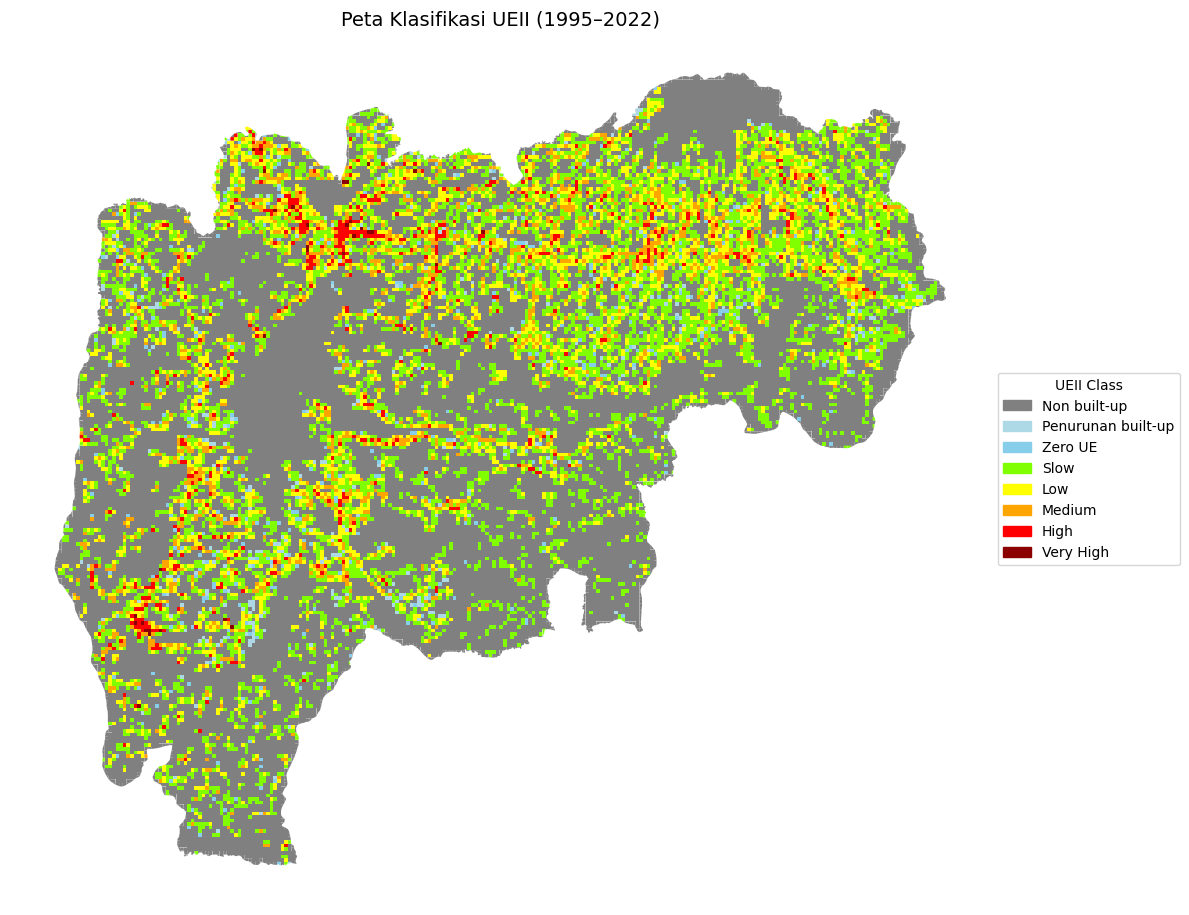

In [25]:
# Definisikan color map kategori UEII
color_map = {
    "Non built-up": "gray",
    "Penurunan built-up": "lightblue",
    "Zero UE": "skyblue",
    "Slow": "Chartreuse",
    "Low": "yellow",
    "Medium": "orange",
    "High": "red",
    "Very High": "darkred"
}

# Tambahkan kolom warna ke GeoDataFrame
grid_clipped["color"] = grid_clipped["UEII_Class"].map(color_map)

# Buat visualisasi peta per kelas secara eksplisit
fig, ax = plt.subplots(figsize=(12, 12))

# Loop tiap kategori dan plot sesuai warna
for cls in color_map.keys():
    subset = grid_clipped[grid_clipped["UEII_Class"] == cls]
    subset.plot(ax=ax, color=color_map[cls], edgecolor="none")

# Buat legend manual agar tidak error
legend_handles = [
    mpatches.Patch(color=color_map[cls], label=cls) for cls in color_map.keys()
]
#plt.legend(handles=legend_handles, title="UEII Class", loc="lower left", frameon=True)
plt.legend(handles=legend_handles, title="UEII Class", loc="center left", bbox_to_anchor=(1, 0.5))
# Judul dan tampilan
plt.title("Peta Klasifikasi UEII (1995–2022)", fontsize=14)
plt.axis("off")
plt.tight_layout()
plt.show()

In [16]:
ueii_wonogiri = gpd.read_file('Wonogiri_UEII/UEII_wonogiri.shp')
ueii_wonogiri["UEII_Class"] = ueii_wonogiri["UEII_Class"].replace({
    "No Activity": "Non Built-up",
    "Decline": "Penurunan Built-up"
})
ueii_wonogiri

,No,Provinsi,Kode_Kab,Kab_Kota,Kode_Prov,builtup_19,builtup_20,builtup__1,builtup__2,UEII,UEII_Class,geometry
0,204.0,JAWA TENGAH,3312,WONOGIRI,33.0,0,0,0.0,0.0,NaN,Non Built-up,"POLYGON ((473323.474 9112271.04, 473323.474 91..."
1,204.0,JAWA TENGAH,3312,WONOGIRI,33.0,0,0,0.0,0.0,NaN,Non Built-up,"POLYGON ((473323.474 9112521.04, 473323.474 91..."
2,204.0,JAWA TENGAH,3312,WONOGIRI,33.0,0,0,0.0,0.0,NaN,Non Built-up,"POLYGON ((473323.474 9112771.04, 473323.474 91..."
3,204.0,JAWA TENGAH,3312,WONOGIRI,33.0,0,0,0.0,0.0,NaN,Non Built-up,"POLYGON ((473323.474 9113021.04, 473323.474 91..."
4,204.0,JAWA TENGAH,3312,WONOGIRI,33.0,0,0,0.0,0.0,NaN,Non Built-up,"POLYGON ((473323.474 9113271.04, 473323.474 91..."
...,...,...,...,...,...,...,...,...,...,...,...,...
31360,204.0,JAWA TENGAH,3312,WONOGIRI,33.0,0,0,0.0,0.0,NaN,Non Built-up,"POLYGON ((535073.474 9131771.04, 535190.495 91..."
31361,204.0,JAWA TENGAH,3312,WONOGIRI,33.0,0,0,0.0,0.0,NaN,Non Built-up,"POLYGON ((535073.474 9131771.04, 535073.474 91..."
31362,204.0,JAWA TENGAH,3312,WONOGIRI,33.0,0,0,0.0,0.0,NaN,Non Built-up,"POLYGON ((535073.474 9132021.04, 535073.474 91..."
31363,204.0,JAWA TENGAH,3312,WONOGIRI,33.0,0,0,0.0,0.0,NaN,Non Built-up,"POLYGON ((535073.474 9132521.04, 535097.17 913..."


## Menghitung Luas dan Persentase Pada Setiap Kelas/Kategori

In [31]:
import pandas as pd
# tiap grid = 6.25 ha
grid_clipped["luas_grid_ha"] = 6.25

# Kelompokkan berdasarkan kelas
tabel_luas = grid_clipped.groupby("UEII_Class")["luas_grid_ha"].sum().reset_index()

# Hitung persentase
total_luas = tabel_luas["luas_grid_ha"].sum()
tabel_luas["persentase"] = (tabel_luas["luas_grid_ha"] / total_luas * 100).round(2)

# Buat urutan
urutan = [
    "Non built-up", "Penurunan built-up", "Zero UE",
    "Slow", "Low", "Medium", "High", "Very High"
]

tabel_luas["UEII_Class"] = pd.Categorical(tabel_luas["UEII_Class"], categories=urutan, ordered=True)
tabel_luas = tabel_luas.sort_values("UEII_Class").reset_index(drop=True)

tabel_luas.columns = ["Kategori UEII", "Luas (ha)", "Persentase (%)"]

# Tampilkan hasil
display(tabel_luas)

#Simpan tabel
tabel_luas.to_csv("tabel_luas_UEII_per_kelas.csv", index=False)

,Kategori UEII,Luas (ha),Persentase (%)
0,Non built-up,114675.00,58.50
1,Penurunan built-up,2368.75,1.21
2,Zero UE,2987.50,1.52
3,Slow,40593.75,20.71
4,Low,20793.75,10.61
5,Medium,10650.00,5.43
6,High,3750.00,1.91
7,Very High,212.50,0.11



---
## Referensi

Alam, I., Nahar, K., & Morshed, M. M. (2023). Measuring urban expansion pattern using spatial matrices in Khulna City, Bangladesh. Heliyon, 9(2).

Dadashpoor, H., & Shahhossein, G. (2024). Defining urban sprawl: A systematic review of 130 definitions. Habitat international, 146, 103039

Desiyana, N. (2016). Dampak urban sprawl terhadap kualitas air dan upaya pengendaliannya. Jurnal Permukiman, 11(2), 76–85.

Indrawati, L., Murti, S. H., Rachmawati, R., & Kurniawan, A. (2020, May). Urban expansion analysis through Remote Sensing and GIS in Semarang-Indonesia. In IOP Conference Series: Earth and Environmental Science (Vol. 485, No. 1, p. 012113). IOP Publishing.

Kassouk, Z., Hammami, H., & Ismail, H. (2022). Studying Sharp Changes of Urban Landscape: Concession Within Agricultural, Hydraulic, and Maritime Public Domain in Kelibia City, Northern Tunisia. Frontiers in Sustainable Cities, 4, 900336.

Mardiansjah, F. H., Sugiri, A., & Sari, G. P. (2019, October). Urban population growth and their implication to agricultural land in the process of metropolitanization: The case of kabupaten sukoharjo, in metropolitan surakarta. In IOP Conference Series: Earth and Environmental Science (Vol. 328, No. 1, p. 012064). IOP Publishing.

Nechyba, T.J. and Walsh, R.P. (2004) Urban Sprawl. Journal of Economic Perspectives, 18, 177-200. http://dx.doi.org/10.1257/0895330042632681

Sartika, E. (2012). DAMPAK ALIH FUNGSI LAHAN PERTANIAN MENJADI LAHAN INDUSTRI TERHADAP KONDISI SOSIAL EKONOMI MASYARAKAT DI KECAMATAN CIKAMPEK KARAWANG (Doctoral dissertation, Universitas Pendidikan Indonesia).

Yunus, H. S. (2000). Struktur tata ruang kota. Pustaka Pelajar.

# Shannon's Entropy

Shannon’s Entropy digunakan untuk mengukur sejauh mana pembangunan menyebar (sprawl) atau terkonsentrasi di suatu wilayah.  
Metode ini umum digunakan untuk menganalisis pola spasial urbanisasi.

### Rumus Shannon’s Entropy:

Hn = –∑(Pi × loge(Pi))

**Keterangan:**
- Hn : Nilai entropy total
- Pi : Proporsi luas built-up di unit ke-i terhadap total built-up seluruh wilayah
- loge : Logaritma natural (basis e)
- ∑ : Jumlah dari seluruh unit spasial (misalnya desa)
- n : Jumlah total unit spasial

Nilai entropy berkisar antara 0 hingga loge(n).  
Semakin mendekati loge(n), semakin tersebar pembangunan.  
Semakin mendekati 0, pembangunan cenderung terkonsentrasi.

---

### Referensi:
Effat, H. A., & El Shobaky, M. A. (2015). Modeling and mapping of urban sprawl pattern in Cairo using multi-temporal landsat images, and Shannon’s entropy. Advances in Remote Sensing, 4(4), 303-318.

## BACA DAN VISUALISASI BATAS ADMINISTRASI DESA

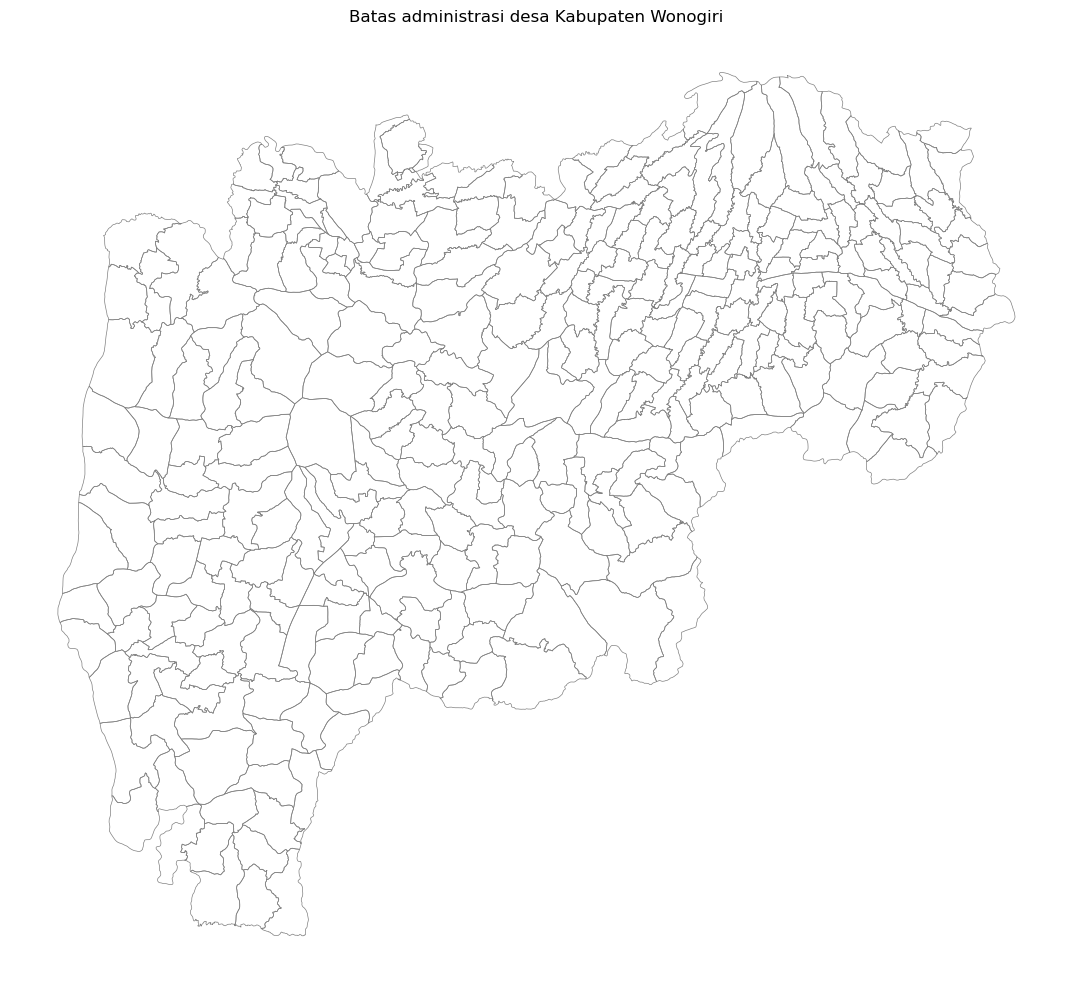

In [2]:
# Baca file shapefile batas administrasi desa di Kabupaten Wonogiri
desa = gpd.read_file('Wonogiri_Shannons Entropy/AdminDesa_Wonogiri.shp')

#Visualisasi
fig, ax = plt.subplots(figsize=(22, 10))
desa.plot(ax=ax, edgecolor="gray", facecolor="none", linewidth=0.5)
ax.set_title("Batas administrasi desa Kabupaten Wonogiri", fontsize=12)
ax.set_axis_off()
plt.tight_layout()
plt.show()

In [38]:
# Pastikan CRS sudah sesuai
desa.crs

<Projected CRS: EPSG:32749>
Name: WGS 84 / UTM zone 49S
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 108°E and 114°E, southern hemisphere between 80°S and equator, onshore and offshore. Australia. Indonesia.
- bounds: (108.0, -80.0, 114.0, 0.0)
Coordinate Operation:
- name: UTM zone 49S
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

## Ekstraksi Lahan Terbangun per Desa (Zonal Statistics) 

Langkah pertama dalam menghitung nilai entropy adalah memperoleh informasi seberapa besar pembangunan (built-up) terjadi di setiap desa.

Untuk itu digunakan metode **zonal statistics**, yaitu menghitung jumlah pixel kelas "built-up" dari raster klasifikasi di dalam batas wilayah setiap desa.

> **Yang dihitung adalah jumlah pixel dan bukan luas lahannya, Karena:**

1. Setiap pixel Landsat memiliki ukuran tetap yaitu 30 × 30 meter = 900 m² = 0.09 hektar.
2. Proporsi \( Pᵢ \) dalam rumus entropy hanya memerlukan perbandingan relatif (misalnya: desa A menyumbang 10% dari total built-up).
3. Karena semua pixel memiliki ukuran yang sama, jumlah pixel sudah mewakili luas secara proporsional.

Dengan demikian, menghitung **jumlah pixel** sudah cukup untuk kebutuhan perhitungan entropy, **tanpa harus dikonversi ke hektar**.


In [5]:
# ZONAL STATISTICS UNTUK ENTROPY (BUILT-UP PER DESA)

# Hitung jumlah pixel dengan nilai 1 (built-up) untuk setiap desa di tahun 1995
zstat_1995 = zonal_stats(
    desa,             # GeoDataFrame batas desa
    class95,          # Raster klasifikasi 1995
    stats="count",    # Hitung jumlah pixel
    categorical=True, # Aktifkan mode kategori
    category_map={1: "builtup"},  # Ambil hanya kelas built-up
    nodata=0          # Abaikan nilai NoData (0)
)

# Ulangi untuk raster tahun 2022
zstat_2022 = zonal_stats(
    desa,
    class22,
    stats="count",
    categorical=True,
    category_map={1: "builtup"},
    nodata=0
)

# Tambahkan hasil jumlah pixel ke GeoDataFrame desa
desa["built_1995"] = [z.get("builtup", 0) for z in zstat_1995]
desa["built_2022"] = [z.get("builtup", 0) for z in zstat_2022]

## Perhitungan Nilai Entropy Total dan Lokal

Terdapat dua jenis nilai entropy yang dihitung:

1. **Entropy total**: Menggambarkan tingkat penyebaran pembangunan di seluruh wilayah (kabupaten).
2. **Entropy lokal**: Menggambarkan kontribusi setiap desa terhadap total entropy, dan digunakan untuk visualisasi peta entropy menggunakan interpolasi.

Perhitungan menggunakan logaritma natural (loge)

In [10]:
# === FUNGSI UNTUK MENGHITUNG ENTROPY TOTAL DAN LOKAL ===

# Fungsi untuk menghitung entropy total seluruh wilayah
def entropy(values):
    props = values / np.sum(values)     # Hitung proporsi masing-masing desa
    props = props[props > 0]            # Hindari log(0) untuk nilai 0
    return -np.sum(props * np.log(props))  # Rumus entropy: -∑(Pᵢ × loge(Pᵢ))

# Fungsi untuk menghitung entropy lokal (per desa)
def entropy_local(values):
    total = np.sum(values)
    return [-(v / total) * np.log(v / total) if v > 0 else 0 for v in values]

In [11]:
# HITUNG ENTROPY TOTAL UNTUK MASING-MASING TAHUN

# Hitung entropy total tahun 1995 dan 2022 berdasarkan jumlah pixel built-up
entropy_1995 = entropy(desa["built_1995"].values)
entropy_2022 = entropy(desa["built_2022"].values)

# Tampilkan hasilnya
print(f"Entropy 1995: {entropy_1995:.4f}")
print(f"Entropy 2022: {entropy_2022:.4f}")
print(f"Perubahan entropy: {entropy_2022 - entropy_1995:.4f}")

Entropy 1995: 5.2973
Entropy 2022: 5.5114
Perubahan entropy: 0.2141


In [12]:
# HITUNG ENTROPY LOKAL PER DESA UNTUK MASING-MASING TAHUN

# Tambahkan kolom entropy lokal tahun 1995
desa["entropy_1995"] = entropy_local(desa["built_1995"].values)

# Tambahkan kolom entropy lokal tahun 2022
desa["entropy_2022"] = entropy_local(desa["built_2022"].values)

In [13]:
desa

,NAMOBJ,WADMKC,geometry,built_1995,built_2022,entropy_1995,entropy_2022
0,Gebangharjo,Pracimantoro,"POLYGON Z ((476260.281 9111711.431 0, 476281.3...",52,268,0.006666,0.012114
1,Sambiroto,Pracimantoro,"POLYGON Z ((481535.792 9109056.885 0, 481528.9...",220,815,0.022348,0.030280
2,Jatirejo,Giritontro,"POLYGON Z ((487384.83 9106155.639 0, 487421.66...",64,259,0.007959,0.011772
3,Platarejo,Giriwoyo,"POLYGON Z ((490181.996 9113497.065 0, 490218.4...",144,506,0.015754,0.020545
4,Basuhan,Eromoko,"POLYGON Z ((477551.627 9115880.775 0, 477419.4...",84,337,0.010025,0.014675
...,...,...,...,...,...,...,...
289,Gambiranom,Kismantoro,"POLYGON Z ((532383.972 9130324.825 0, 532398.9...",119,245,0.013437,0.011234
290,Kopen,Jatipurno,"POLYGON Z ((513797.476 9139131.72 0, 513805.40...",133,471,0.014745,0.019368
291,Tawangrejo,Jatipurno,"POLYGON Z ((517002.1 9140125.971 0, 516986.225...",204,562,0.021007,0.022392
292,Randusari,Slogohimo,"POLYGON Z ((523256.02 9136802.72 0, 523256.164...",58,383,0.007318,0.016323


## Pembuatan Titik Representatif untuk Interpolasi Entropy

Untuk memetakan nilai entropy lokal dalam bentuk peta kontinu, diperlukan **titik representatif** dari setiap desa.  
Titik ini akan digunakan sebagai lokasi input untuk interpolasi spasial (IDW – Inverse Distance Weighted).

Dalam tahap ini:
- Titik yang digunakan adalah **centroid geometris** dari tiap desa.
- Titik tersebut akan menyimpan nilai entropy lokal untuk masing-masing tahun (1995 & 2022).

> Catatan: Jika desa memiliki bentuk sangat kompleks atau tidak beraturan, lebih disarankan menggunakan `.representative_point()` dibanding `.centroid`, agar titik benar-benar berada di dalam poligon.

In [14]:
# MEMBUAT TITIK ENTROPY UNTUK INTERPOLASI SPASIAL

# Buat kolom titik centroid dari setiap desa (berfungsi sebagai lokasi nilai entropy lokal)
desa["centroid"] = desa.geometry.centroid  # opsional: ganti dengan .representative_point() jika perlu

# Buat GeoDataFrame baru yang berisi nilai entropy lokal dan titiknya
gdf_point = gpd.GeoDataFrame(
    desa[["entropy_1995", "entropy_2022"]],
    geometry=desa["centroid"],
    crs=desa.crs
)

In [15]:
gdf_point

,entropy_1995,entropy_2022,geometry
0,0.006666,0.012114,POINT (475042.883 9111143.504)
1,0.022348,0.030280,POINT (481409.22 9108076.811)
2,0.007959,0.011772,POINT (486906.953 9104793.206)
3,0.015754,0.020545,POINT (488864.185 9111326.998)
4,0.010025,0.014675,POINT (475317.945 9116928.798)
...,...,...,...
289,0.013437,0.011234,POINT (530258.081 9130064.443)
290,0.014745,0.019368,POINT (512992.611 9137570.597)
291,0.021007,0.022392,POINT (516521.079 9138265.925)
292,0.007318,0.016323,POINT (522086.811 9137964.819)


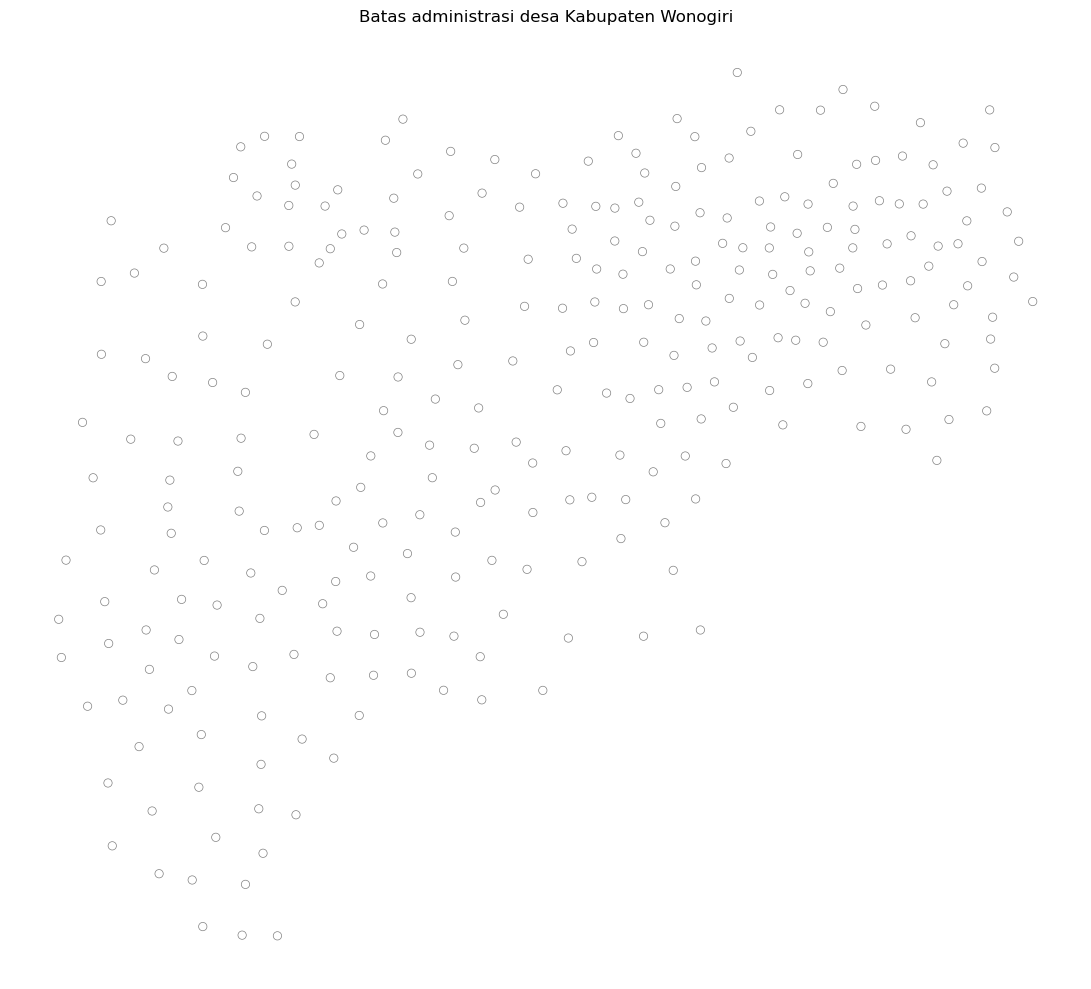

In [16]:
# Visualisasi titik centroid

fig, ax = plt.subplots(figsize=(22, 10))
gdf_point.plot(ax=ax, edgecolor="gray", facecolor="none", linewidth=0.5)
ax.set_title("Batas administrasi desa Kabupaten Wonogiri", fontsize=12)
ax.set_axis_off()
plt.tight_layout()
plt.show()

In [81]:
#Menyipan GeoDataFrame baru yang berisi nilai entropy lokal dan titiknya
gdf_point.to_file("entropy_wonogiri.shp")

/tmp/ipykernel_617621/1503506092.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_point.to_file("entropy_wonogiri.shp")
/home/ubuntu/miniforge3/envs/cubeenv/lib/python3.12/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'entropy_1995' to 'entropy_19'
  ogr_write(
/home/ubuntu/miniforge3/envs/cubeenv/lib/python3.12/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'entropy_2022' to 'entropy_20'
  ogr_write(


In [ ]:




def idw_from_points(gdf_points, value_col, polygon_gdf, resolution=250, power=2):
    """
    Interpolasi IDW dari titik ke raster, dibatasi bounding box dari polygon (desa/kabupaten).
    """
    # Ambil batas spasial dari polygon (desa/kabupaten)
    minx, miny, maxx, maxy = polygon_gdf.total_bounds

    xi = np.arange(minx, maxx, resolution)
    yi = np.arange(miny, maxy, resolution)
    xi, yi = np.meshgrid(xi, yi)
    grid_coords = np.vstack((xi.ravel(), yi.ravel())).T

    # Ambil titik dan nilai
    x = gdf_points.geometry.x.values
    y = gdf_points.geometry.y.values
    z = gdf_points[value_col].values

    # Interpolasi IDW
    tree = cKDTree(np.vstack((x, y)).T)
    dist, idx = tree.query(grid_coords, k=6)
    weights = 1 / np.power(dist, power)
    weights[np.isinf(weights)] = 0

    z_idw = np.sum(weights * z[idx], axis=1) / np.sum(weights, axis=1)
    z_idw = z_idw.reshape(xi.shape)

    # Buat DataArray
    da = xr.DataArray(
        z_idw,
        dims=("y", "x"),
        coords={"y": yi[:, 0], "x": xi[0, :]}
    )
    transform = from_origin(xi.min(), yi.max(), resolution, resolution)
    da.rio.write_crs(polygon_gdf.crs, inplace=True)
    da.rio.write_transform(transform, inplace=True)

    return da

## Fungsi Interpolasi IDW (Inverse Distance Weighted)
Interpolasi IDW (Inverse Distance Weighted) digunakan untuk membuat peta sebaran nilai entropy lokal berdasarkan titik centroid desa.

In [17]:
def idw(gdf_points, value_col, polygon_gdf, resolution=250, power=2):
    """
    Interpolasi IDW dari titik ke raster, dibatasi bounding box dari polygon (desa/kabupaten).
    
    Parameters:
        gdf_points    : GeoDataFrame titik (contoh: centroid desa)
        value_col     : Nama kolom nilai yang ingin diinterpolasi (contoh: 'entropy_1995')
        polygon_gdf   : GeoDataFrame polygon (batas kabupaten wonogiri) untuk menentukan batas interpolasi
        resolution    : Ukuran grid output dalam meter (default 250 m)
        power         : Pangkat dalam perhitungan IDW (default 2 = kuadrat)
    """
    
    # Ambil batas spasial dari polygon (batas kabupaten)
    minx, miny, maxx, maxy = polygon_gdf.total_bounds

    # Buat grid koordinat (xi, yi) dengan resolusi tertentu
    xi = np.arange(minx, maxx, resolution)
    yi = np.arange(miny, maxy, resolution)
    xi, yi = np.meshgrid(xi, yi)
    grid_coords = np.vstack((xi.ravel(), yi.ravel())).T

    # Ambil koordinat titik dan nilai entropy-nya
    x = gdf_points.geometry.x.values
    y = gdf_points.geometry.y.values
    z = gdf_points[value_col].values

    # KDTree untuk pencarian tetangga terdekat (nearest neighborhood)
    tree = cKDTree(np.vstack((x, y)).T)
    dist, idx = tree.query(grid_coords, k=6)  # ambil 6 tetangga terdekat

    # Hitung bobot IDW
    weights = 1 / np.power(dist, power)
    weights[np.isinf(weights)] = 0  # hindari pembagian dengan 0

    # Hitung nilai interpolasi
    z_idw = np.sum(weights * z[idx], axis=1) / np.sum(weights, axis=1)
    z_idw = z_idw.reshape(xi.shape)

    # Konversi ke xarray.DataArray untuk rasterisasi
    da = xr.DataArray(
        z_idw,
        dims=("y", "x"),
        coords={"y": yi[:, 0], "x": xi[0, :]}
    )

    # Tambahkan metadata spasial: CRS dan transformasi raster
    transform = from_origin(xi.min(), yi.max(), resolution, resolution)
    da.rio.write_crs(polygon_gdf.crs, inplace=True)
    da.rio.write_transform(transform, inplace=True)

    return da

In [19]:
# Penggunaan fungsi Interpolasi IDW
idw_1995 = idw(gdf_point, "entropy_1995", desa)
idw_2022 = idw(gdf_point, "entropy_2022", desa)

In [21]:
# Clip IDW berdasarkan batas administrasi
idw_clip1995 = idw_1995.rio.clip(desa.geometry.values, desa.crs, drop=True)
idw_clip2022 = idw_2022.rio.clip(desa.geometry.values, desa.crs, drop=True)

## Visualisasi Hasil Interpolasi Entropy (IDW)

Fungsi `plot_idw()` berikut digunakan untuk memvisualisasikan `xarray.DataArray` hasil interpolasi yang telah diklip sesuai batas wilayah studi.

Peta ini menampilkan sebaran spasial nilai entropy lokal untuk masing-masing tahun, dengan pewarnaan berdasarkan skala bertingkat (misalnya, `YlOrRd`).

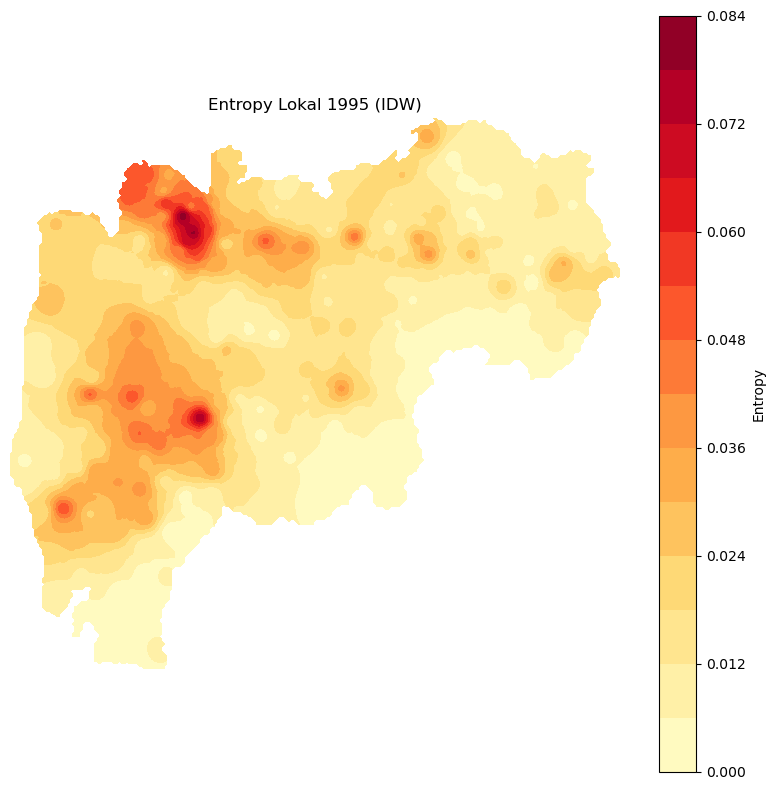

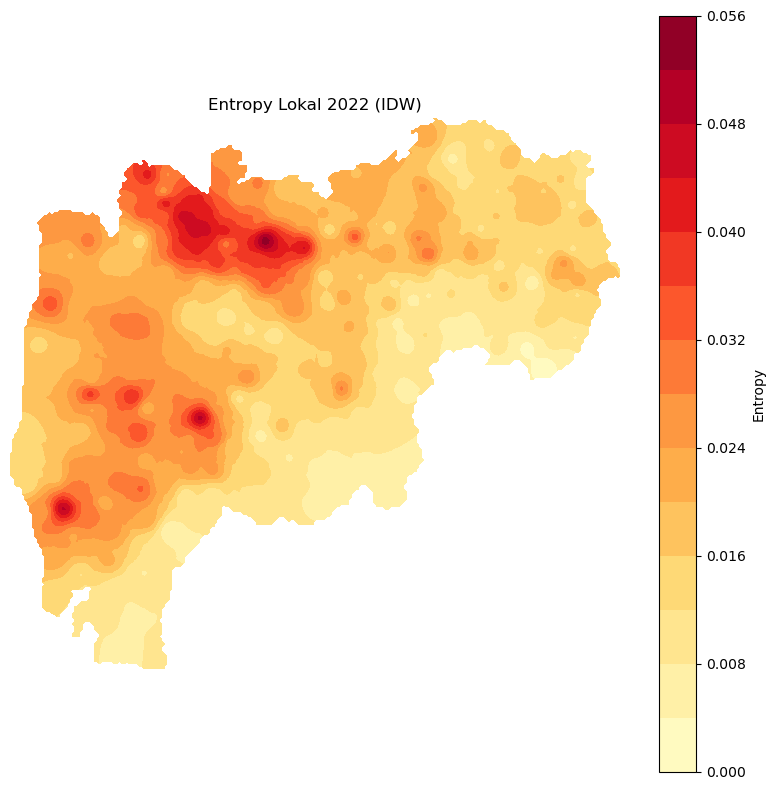

In [25]:
def plot_idw(dataarray, title="Peta Entropy IDW", cmap="YlOrRd", levels=15):
    """
    Visualisasi hasil raster interpolasi IDW (xarray.DataArray).
    
    Parameters:
        dataarray : Raster hasil IDW dalam format xarray.DataArray
        title     : Judul peta
        cmap      : Colormap (skema warna), default "YlOrRd"
        levels    : Jumlah tingkatan kontur (warna bertingkat)
    """
    # Mask nilai NaN agar tidak ikut divisualisasi
    masked_data = ma.masked_invalid(dataarray.values)
    
    # Setup figure dan axis
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Plot kontur IDW
    cs = ax.contourf(
        dataarray["x"], dataarray["y"], masked_data,
        levels=levels, cmap=cmap
    )

    # Jika ingin menambahkan batas administrasi, aktifkan baris di bawah:
    # desa.boundary.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=0.5)

    # Set rentang sumbu agar sesuai dengan data raster
    ax.set_xlim(dataarray["x"].min(), dataarray["x"].max())
    ax.set_ylim(dataarray["y"].min(), dataarray["y"].max())
    ax.set_aspect("equal")

    # Tambahkan judul dan legend warna
    ax.set_title(title)
    ax.axis("off")
    plt.colorbar(cs, ax=ax, label="Entropy")
    plt.tight_layout()
    plt.show()

# Visualisasikan entropy IDW tahun 1995 dan 2022
plot_idw(idw_clip1995, title="Entropy Lokal 1995 (IDW)")
plot_idw(idw_clip2022, title="Entropy Lokal 2022 (IDW)")

In [103]:
#Menyimpan hasil interpolasi IDW
idw_clip1995.rio.to_raster("entropy_1995.tif")
idw_clip2022.rio.to_raster("entropy_2022.tif")